🐺 Initializing Cerberus Ensemble on cuda...
🔄 Loading Weights...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🤖 Dual-Stream Inference...
👀 CNN Inference...


c:\Users\sreeh\miniconda3\envs\your_env_name\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


🦖 DINOv2 Inference...

🏆 CERBERUS ENSEMBLE ACCURACY: 89.26%
------------------------------------------------------------
                        precision    recall  f1-score   support

      Cysts_Structural       0.65      0.59      0.62        22
             Dysarthia       1.00      1.00      1.00        42
            Laryngitis       0.64      0.83      0.72        42
           Vox senilis       0.85      0.87      0.86        93
             parkinson       0.99      0.97      0.98       200
spasmodische_dysphonie       0.80      0.40      0.53        20

              accuracy                           0.89       419
             macro avg       0.82      0.78      0.79       419
          weighted avg       0.90      0.89      0.89       419



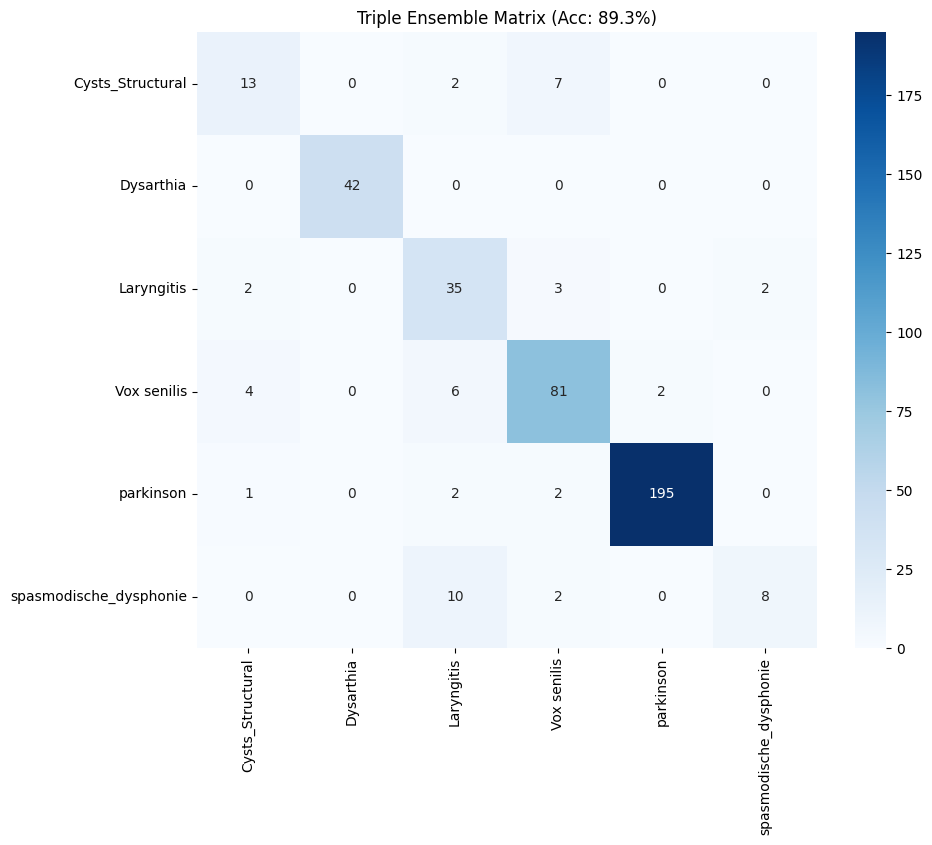

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchaudio
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SFM_CSV = "sfm_features.csv"
BATCH_SIZE = 8
DINO_MODEL_NAME = "facebook/dinov2-small" 

print(f"🐺 Initializing Cerberus Ensemble on {DEVICE}...")

# ==========================================
# 1. DEFINE DATASETS
# ==========================================

# A. Dual-Stream Dataset
class DualStreamDataset(Dataset):
    def __init__(self, df, sfm_scaler, sfm_cols):
        self.df = df.reset_index(drop=True)
        self.sfm_scaler = sfm_scaler
        self.sfm_cols = sfm_cols
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        raw_sfm = row[self.sfm_cols].values.astype(np.float32)
        norm_sfm = self.sfm_scaler.transform([raw_sfm])[0]
        return row['file_path'], torch.tensor(norm_sfm, dtype=torch.float32), torch.tensor(row['label_encoded'], dtype=torch.long)

def dual_collate(batch):
    paths = [item[0] for item in batch] 
    sfms = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return paths, sfms, labels

# B. CNN Dataset
class CNNDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((128, 128))
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: wav, sr = torchaudio.load(row['file_path'])
        except: wav = torch.zeros(1, 16000*3); sr=16000
        if sr!=16000: wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        img = self.resize(self.db(self.mel(wav)))
        img = (img - img.mean()) / (img.std() + 1e-6)
        return img, torch.tensor(row['label_encoded'], dtype=torch.long)

# C. DINO Dataset
class DinoDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, n_mels=128)
        self.db = torchaudio.transforms.AmplitudeToDB()
        self.resize = T.Resize((224, 224))
        self.norm = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try: wav, sr = torchaudio.load(row['file_path'])
        except: wav = torch.zeros(1, 16000*3); sr=16000
        if sr!=16000: wav = torchaudio.transforms.Resample(sr, 16000)(wav)
        img = self.resize(self.db(self.mel(wav))).repeat(3, 1, 1)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        return self.norm(img), torch.tensor(row['label_encoded'], dtype=torch.long)

# ==========================================
# 2. DEFINE MODELS (FIXED)
# ==========================================

class DualStreamModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.audio_encoder = AutoModel.from_pretrained("hance-ai/audiomae", trust_remote_code=True)
        self.audio_proj = nn.Linear(768, 512)
        self.sfm_mlp = nn.Sequential(nn.Linear(10, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 512), nn.LayerNorm(512))
        self.cross_attn = nn.MultiheadAttention(512, 8, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, num_classes))
    
    def forward(self, paths, sfms):
        device = self.audio_proj.weight.device
        audio = torch.stack([self.audio_encoder(p) for p in paths]).to(device).view(len(paths), 768, -1).permute(0, 2, 1)
        audio = self.audio_proj(audio)
        
        # --- FIX IS HERE ---
        # We must use the input argument 'sfms'
        sfm_emb = self.sfm_mlp(sfms) 
        
        attn, _ = self.cross_attn(sfm_emb.unsqueeze(1), audio, audio)
        return self.classifier(attn.squeeze(1)), None

class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_classes))
    def forward(self, x): return self.fc(self.flatten(self.conv3(self.conv2(self.conv1(x)))))

class DinoV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.dino = AutoModel.from_pretrained(DINO_MODEL_NAME)
        hidden_size = self.dino.config.hidden_size 
        self.classifier = nn.Sequential(nn.Linear(hidden_size, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(0.4), nn.Linear(512, num_classes))
    def forward(self, x):
        out = self.dino(pixel_values=x)
        cls = out.pooler_output if out.pooler_output is not None else out.last_hidden_state[:, 0]
        return self.classifier(cls)

# ==========================================
# 3. SETUP & RUN
# ==========================================
full_df = pd.read_csv(SFM_CSV)
le = LabelEncoder()
full_df['label_encoded'] = le.fit_transform(full_df['label_name'])
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
NUM_CLASSES = len(le.classes_)

# Scaler
sfm_cols = ['jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3', 'hnr', 'f1', 'f2', 'f3', 'f4', 'f0_mean']
scaler = StandardScaler().fit(full_df[full_df['split'] == 'train'][sfm_cols].values)

# Loaders
loader_dual = DataLoader(DualStreamDataset(test_df, scaler, sfm_cols), batch_size=BATCH_SIZE, shuffle=False, collate_fn=dual_collate)
loader_cnn  = DataLoader(CNNDataset(test_df), batch_size=BATCH_SIZE, shuffle=False)
loader_dino = DataLoader(DinoDataset(test_df), batch_size=BATCH_SIZE, shuffle=False)

# Load Models
print("🔄 Loading Weights...")
m_dual = DualStreamModel(NUM_CLASSES).to(DEVICE)
m_dual.load_state_dict(torch.load(r"DualStream\Models\WeightedDualStream\best_weighted_model.pth"))
m_dual.eval()

m_cnn = BasicCNN(NUM_CLASSES).to(DEVICE)
m_cnn.load_state_dict(torch.load(r"CNN\Models\baseline_basic_cnn.pth"))
m_cnn.eval()

m_dino = DinoV2Classifier(NUM_CLASSES).to(DEVICE)
m_dino.load_state_dict(torch.load("best_dinov2_model.pth"))
m_dino.eval()

# Inference
probs_dual, probs_cnn, probs_dino, true_labels = [], [], [], []

print("🤖 Dual-Stream Inference...")
with torch.no_grad():
    for p, s, l in loader_dual:
        # Fixed call here
        probs_dual.append(F.softmax(m_dual(p, s.to(DEVICE))[0], dim=1).cpu().numpy())
        true_labels.append(l.numpy())

print("👀 CNN Inference...")
with torch.no_grad():
    for i, _ in loader_cnn: probs_cnn.append(F.softmax(m_cnn(i.to(DEVICE)), dim=1).cpu().numpy())

print("🦖 DINOv2 Inference...")
with torch.no_grad():
    for i, _ in loader_dino: probs_dino.append(F.softmax(m_dino(i.to(DEVICE)), dim=1).cpu().numpy())

# Merge
p_dual = np.concatenate(probs_dual)
p_cnn  = np.concatenate(probs_cnn)
p_dino = np.concatenate(probs_dino)
y_true = np.concatenate(true_labels)

# Triple Vote (40/40/20)
final_probs = (0.4 * p_dual) + (0.4 * p_dino) + (0.2 * p_cnn)
y_pred = np.argmax(final_probs, axis=1)

# Results
acc = accuracy_score(y_true, y_pred)
print(f"\n🏆 CERBERUS ENSEMBLE ACCURACY: {acc*100:.2f}%")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=le.classes_))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Triple Ensemble Matrix (Acc: {acc*100:.1f}%)')
plt.show()